In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
from dask.distributed import Client
from dask.distributed import progress

In [2]:
# bad_df_shape = (3847460917, 6)
bad_df_shape =   (3200000000, 6)

In [3]:
from dask.distributed import Client
from dask.distributed import progress

# Create a connection to the Dask cluster. The dask-scheduler must be running on
# the same machine as this notebook and listening for inbound clients at port 5555.
client = Client('localhost:5555')

In [5]:
# Collect the descriptions of each worker (<host>:<port>) into a list. Print out how many workers we have.

workers = [x[6:] for x in client.scheduler_info()['workers'].keys()]
len(workers)

64

In [6]:
workers[:5]

['10.222.10.131:37831',
 '10.222.10.131:38133',
 '10.222.10.131:40864',
 '10.222.10.131:45083',
 '10.222.10.131:45240']

In [7]:
rows_per_worker = int((bad_df_shape[0] + len(workers) - 1) / len(workers))
rows_per_worker

50000000

In [8]:
import dask.array as da
import dask

def load_chunk_of_bad_data(nrecords):
    return np.random.rand(nrecords, 6)

chunks_per_worker = 10
chunk_size = int(rows_per_worker / chunks_per_worker)

all_delayed = []
for w in range(len(workers)):
    start_row = w * rows_per_worker
    end_row = (w + 1) * rows_per_worker
    if end_row > bad_df_shape[0]:
        end_row = bad_df_shape[0]

    worker = workers[w]
    x = dask.delayed(load_chunk_of_bad_data)(end_row - start_row)
    x = da.from_delayed(x, shape = (end_row - start_row, 6), dtype=float)
    x = x.rechunk((chunk_size, -1))
    all_delayed.append(x)

In [9]:
# Concatenate all of the arrays we just loaded individually on each worker into a single, logical, global array
# so that we can operate on it as a single entity.

dist_bad_df = da.concatenate(all_delayed, axis = 0)
dist_bad_df = dist_bad_df.persist()
dist_bad_df

dask.array<concatenate, shape=(3200000000, 6), dtype=float64, chunksize=(5000000, 6)>

In [10]:
%%time
# Just to make sure everything worked, glance at the first 5 rows of our globally distributed array.
dist_bad_df[:5, :].compute()

CPU times: user 14.5 ms, sys: 5.79 ms, total: 20.2 ms
Wall time: 3.12 s


array([[ 0.2481061 ,  0.54395154,  0.65272167,  0.43346395,  0.93913228,
         0.23735166],
       [ 0.36886134,  0.5205662 ,  0.62998593,  0.15110813,  0.15967887,
         0.75349068],
       [ 0.88162457,  0.00257781,  0.67075228,  0.32088316,  0.10245093,
         0.97378567],
       [ 0.62263075,  0.73209041,  0.80858509,  0.25899956,  0.32133552,
         0.03037572],
       [ 0.98358528,  0.76943356,  0.03518472,  0.30579856,  0.57920286,
         0.46482212]])

In [11]:
%%time
# Heck of a lot faster the second time because of lazy evaluation
dist_bad_df[:5, :].compute()

CPU times: user 3.45 ms, sys: 1.3 ms, total: 4.75 ms
Wall time: 8.43 ms


array([[ 0.2481061 ,  0.54395154,  0.65272167,  0.43346395,  0.93913228,
         0.23735166],
       [ 0.36886134,  0.5205662 ,  0.62998593,  0.15110813,  0.15967887,
         0.75349068],
       [ 0.88162457,  0.00257781,  0.67075228,  0.32088316,  0.10245093,
         0.97378567],
       [ 0.62263075,  0.73209041,  0.80858509,  0.25899956,  0.32133552,
         0.03037572],
       [ 0.98358528,  0.76943356,  0.03518472,  0.30579856,  0.57920286,
         0.46482212]])

In [12]:
%%time
# Ask dask to rebalance the data across worker nodes. This may do nothing, but we've also seen dask
# make some very dump load balancing decisions (i.e. all data on one node) so we do this to be safe.
client.rebalance(workers)

CPU times: user 413 µs, sys: 1.11 ms, total: 1.52 ms
Wall time: 2.68 ms


In [13]:
# Verify that the shape reported for our global dask array matches the shape of the array we originally loaded from disk locally

dist_bad_df.shape

(3200000000, 6)

In [14]:
# Necessary for KMeans to accept this array for clustering.

dist_bad_df = dist_bad_df.rechunk((dist_bad_df.chunks[0], -1))

In [15]:
dist_bad_df.chunks[1]

(6,)

In [ ]:
from dask_ml.cluster import KMeans
import time
import sys

# Use Dask's distributed KMeans implementation to produce clusters (instead of sklearn's mini batch kmeans).
#
# Here we try the clustering 10 times with a different random seed each time, and then choose the best result.

nrepeats = 5
niters = 5
models = []
elapsed_times = []
for r in range(nrepeats):
    model = KMeans(n_clusters = 2, max_iter = niters, tol = 1e-30)
    
    start_time = time.time()
    transformed = model.fit(dist_bad_df)
    elapsed_time = time.time() - start_time

    models.append(model)
    elapsed_times.append(elapsed_time)
    sys.stderr.write('repeat ' + str(r) + ' took ' + str(elapsed_time) + ' s\n')

elapsed_times

repeat 0 took 684.982702255249 s
repeat 1 took 654.6165082454681 s
repeat 2 took 624.7370493412018 s


In [17]:
for m in range(len(models)):
    if model.n_iter_ != niters:
        print(m, model.n_iter_, niters)

0 3 5
1 3 5
2 3 5
3 3 5
4 3 5


In [25]:
sum(elapsed_times) / len(elapsed_times), min(elapsed_times)

(2535.6976708889006, 1029.9860525131226)

In [23]:
%%time
local_df = dist_bad_df.compute()

CPU times: user 8.92 s, sys: 17.8 s, total: 26.8 s
Wall time: 53.3 s


In [24]:
client.close()

In [ ]:
from sklearn.cluster import KMeans

models = []
elapsed_times = []
for r in range(nrepeats):
    model = KMeans(n_clusters = 2, max_iter = niters + 1, tol = 1e-30, n_init = 1)
    
    start_time = time.time()
    transformed = model.fit(local_df)
    elapsed_time = time.time() - start_time
    
    models.append(model)
    elapsed_times.append(elapsed_time)

elapsed_times

In [1]:
for model in models:
    assert model.n_iter_ == niters, (model.n_iter_, niters)

NameError: name 'models' is not defined

In [26]:
sum(elapsed_times) / len(elapsed_times)

229.99075269699097

In [ ]:
sum(elapsed_times) / len(elapsed_times)

### Looking at dask scaling on hpchw4831, hpchw4832, hpchw4833, hpchw4834

|model   | # records     | clusters | repeats | iterations | machines | processes per machine | threads per process | elapsed time (s)   |
|--------|---------------|----------|---------|------------|----------|-----------------------|---------------------|--------------------|
|sklearn | 100,000,000   | 2        | 5       | 5          | 1        |                       |                     | 57.37087316513062  |
|sklearn | 200,000,000   | 2        | 5       | 5          | 1        |                       |                     | 114.86511063575745 |
|sklearn | 400,000,000   | 2        | 5       | 5          | 1        |                       |                     | 229.99075269699097 |
|sklearn | 800,000,000   | 2        | 5       | 5          | 1        |                       |                     | OOM                |
| |  |         |        |           |         |                       |                     |  |
|dask    | 400,000,000   | 2        | 5       | 5          | 4        | 8                     | 3                   |    |
|dask    | 800,000,000   | 2        | 5       | 5          | 4        | 8                     | 3                   |    |
|dask    | 1,600,000,000 | 2        | 5       | 5          | 4        | 8                     | 3                   |    |
| |  |         |        |           |         |                       |                     |  |
|dask    | 800,000,000 | 2        | 5       | 5          | 2 (hpchw4831,2)               | 8                        | 3                  | 330.03280782699585 |
|dask    | 800,000,000 | 2        | 5       | 5          | 4 (hpchw4831,2,3,4)           | 8                        | 3                  | 255.93871474266052 |
|dask    | 800,000,000 | 2        | 5       | 5          | 6 (hpchw4831,2,3,4,5,6)       | 8                        | 3                  | 249.29323554039001 |
|dask    | 800,000,000 | 2        | 5       | 5          | 8 (hpchw4831,2,3,4,5,6,7,8)   | 8                        | 3                  | 192.52172231674194 |
| |  |         |        |           |         |                       |                     |  |
|dask    | 1,600,000,000 | 2        | 5       | 5          | 2 (hpchw4831,2)               | 8                        | 3                  |  |
|dask    | 1,600,000,000 | 2        | 5       | 5          | 4 (hpchw4831,2,3,4)           | 8                        | 3                  |  |
|dask    | 1,600,000,000 | 2        | 5       | 5          | 6 (hpchw4831,2,3,4,5,6)       | 8                        | 3                  | 1120.9423038959503 |
|dask    | 1,600,000,000 | 2        | 5       | 5          | 8 (hpchw4831,2,3,4,5,6,7,8)   | 8                        | 3                  | 313.1888620853424 |

|model   | # records     | clusters | repeats | iterations | machines | processes per machine | threads per process | elapsed time (s)   |
|--------|---------------|----------|---------|------------|----------|-----------------------|---------------------|--------------------|
|sklearn | 100,000,000   | 2        | 5       | 5          | 1        |                       |                     | 57.37087316513062  |
|sklearn | 200,000,000   | 2        | 5       | 5          | 1        |                       |                     | 114.86511063575745 |
|sklearn | 400,000,000   | 2        | 5       | 5          | 1        |                       |                     | 229.99075269699097 |
|sklearn | 800,000,000   | 2        | 5       | 5          | 1        |                       |                     | OOM                |
| |  |         |        |           |         |                       |                     |  |
|dask    | 100,000,000   | 2        | 5       | 5          | 2        | 2                     | 24                  | 123.81572861671448   |
|dask    | 200,000,000   | 2        | 5       | 5          | 2        | 2                     | 24                  | 258.71336379051206 |
| |  |         |        |           |         |                       |                     |  |
|dask    | 100,000,000   | 2        | 5       | 5          | 4        | 2                     | 24                  | 86.6988452911377   |
|dask    | 200,000,000   | 2        | 5       | 5          | 4        | 2                     | 24                  | 141.2972318649292  |
| |  |         |        |           |         |                       |                     |  |
|dask    | 100,000,000   | 2        | 5       | 5          | 6        | 2                     | 24                  | 72.81405272483826  |
|dask    | 200,000,000   | 2        | 5       | 5          | 6        | 2                     | 24                  | 113.55892267227173 |
|dask    | 400,000,000   | 2        | 5       | 5          | 6        | 2                     | 24                  | 218.94874792099    |
|dask    | 800,000,000   | 2        | 5       | 5          | 6        | 2                     | 24                  | 371.98787117004395 |
|dask    | 1,600,000,000 | 2        | 5       | 5          | 6        | 2                     | 24                  | 1161.7001044750214 |

|model   | # records     | clusters | repeats | iterations | machines | processes per machine | threads per process | elapsed time (s)   |
|--------|---------------|----------|---------|------------|----------|-----------------------|---------------------|--------------------|
|dask    | 100,000,000   | 2        | 5       | 5          | 6        | 2                     | 24                  | 72.81405272483826  |
|dask    | 200,000,000   | 2        | 5       | 5          | 6        | 2                     | 24                  | 113.55892267227173 |
|dask    | 400,000,000   | 2        | 5       | 5          | 6        | 2                     | 24                  | 218.94874792099    |
|dask    | 800,000,000   | 2        | 5       | 5          | 6        | 2                     | 24                  | 371.98787117004395 |
|dask    | 1,600,000,000 | 2        | 5       | 5          | 6        | 2                     | 24                  | 1161.7001044750214 |
| |  |         |        |           |         |                       |                     |  |
|dask    | 100,000,000   | 2        | 5       | 5          | 6        | 4                     | 12                  | 74.7569028377533   |
|dask    | 200,000,000   | 2        | 5       | 5          | 6        | 4                     | 12                  | 108.41277861595154 |
|dask    | 400,000,000   | 2        | 5       | 5          | 6        | 4                     | 12                  | 155.05894827842712 |
|dask    | 800,000,000   | 2        | 5       | 5          | 6        | 4                     | 12                  | 291.241627073288   |
| |  |         |        |           |         |                       |                     |  |
|dask    | 100,000,000   | 2        | 5       | 5          | 6        | 8                     | 6                   | 108.579838514328   |
|dask    | 200,000,000   | 2        | 5       | 5          | 6        | 8                     | 6                   | 135.68784761428833 |
|dask    | 400,000,000   | 2        | 5       | 5          | 6        | 8                     | 6                   | 187.0207820892334  |
|dask    | 800,000,000   | 2        | 5       | 5          | 6        | 8                     | 6                   | 295.3570291996002  |
|dask    | 1,600,000,000 | 2        | 5       | 5          | 6        | 8                     | 6                   | 615.1828716754914  |
| |  |         |        |           |         |                       |                     |  |
|dask    | 100,000,000   | 2        | 5       | 5          | 6        | 12                    | 4                   | 150.54672794342042 |
|dask    | 200,000,000   | 2        | 5       | 5          | 6        | 12                    | 4                   | 177.17852234840393 |
|dask    | 400,000,000   | 2        | 5       | 5          | 6        | 12                    | 4                   | 229.65289607048035 (lots of GC) |
| |  |         |        |           |         |                       |                     |  |
|dask    | 100,000,000   | 2        | 5       | 5          | 6        | 8                     | 1                   | 117.88140172958374 |

|model   | # records     | clusters | repeats | iterations | machines | processes per machine | threads per process | elapsed time (s)   |
|--------|---------------|----------|---------|------------|----------|-----------------------|---------------------|--------------------|
|sklearn | 400,000,000   | 2        | 5       | 5          | 1        |                       |                     | 229.99075269699097 |
|dask    | 400,000,000   | 2        | 5       | 5          | 2        | 8                     | 6                   | 264.53171052932737 |
|dask    | 400,000,000   | 2        | 5       | 5          | 4        | 8                     | 6                   | 192.60448741912842 |
|dask    | 400,000,000   | 2        | 5       | 5          | 6        | 8                     | 6                   | 187.0207820892334  |

|model   | # records     | clusters | repeats | iterations | machines | processes per machine | threads per process | elapsed time (s)   |
|--------|---------------|----------|---------|------------|----------|-----------------------|---------------------|--------------------|
|dask    | 100,000,000   | 2        | 5       | 5          | 6        | 8                     | 6                   | 108.579838514328   |
|dask    | 200,000,000   | 2        | 5       | 5          | 6        | 8                     | 6                   | 135.68784761428833 |
|dask    | 400,000,000   | 2        | 5       | 5          | 6        | 8                     | 6                   | 187.0207820892334  |
|dask    | 800,000,000   | 2        | 5       | 5          | 6        | 8                     | 6                   | 295.3570291996002  |
|dask    | 1,600,000,000 | 2        | 5       | 5          | 6        | 8                     | 6                   | 615.1828716754914  |

|model   | # records     | clusters | repeats | iterations | machines | processes per machine | threads per process | elapsed time (s)   |
|--------|---------------|----------|---------|------------|----------|-----------------------|---------------------|--------------------|
|dask    | 400,000,000   | 2        | 5       | 5          | 6        | 2                     | 12                  | 198.51 |
|dask    | 400,000,000   | 2        | 5       | 5          | 6        | 4                     | 6                   | 185.04 |
|dask    | 400,000,000   | 2        | 5       | 5          | 6        | 8                     | 3                   | 216.27  |
|dask    | 400,000,000   | 2        | 5       | 5          | 6        | 12                    | 2                   | (lots of GC) 341.79 |
|dask    | 400,000,000   | 2        | 5       | 5          | 6        | 24                    | 1                   | (lots of GC) 369.08 |

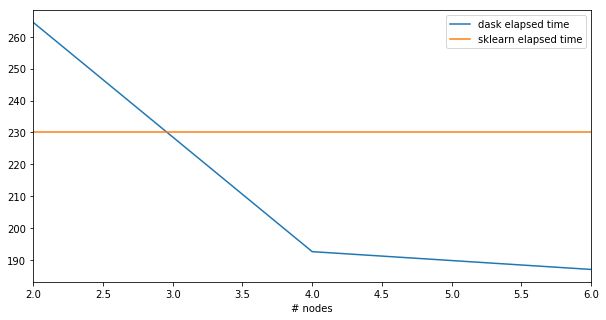

In [21]:
# Look at scaling as you increase the number of nodes

scaling = pd.DataFrame([{'# nodes': 2, 'dask elapsed time': 264.53171052932737, 'sklearn elapsed time': 229.99075269699097},
                        {'# nodes': 4, 'dask elapsed time': 192.60448741912842,  'sklearn elapsed time': 229.99075269699097},
                        {'# nodes': 6, 'dask elapsed time': 187.0207820892334, 'sklearn elapsed time': 229.99075269699097}])
scaling.plot(kind = 'line', figsize = (10, 5), x = '# nodes', y = ['dask elapsed time', 'sklearn elapsed time'])

In [23]:
scaling

,# nodes,dask elapsed time,sklearn elapsed time
0,2,264.531711,229.990753
1,4,192.604487,229.990753
2,6,187.020782,229.990753


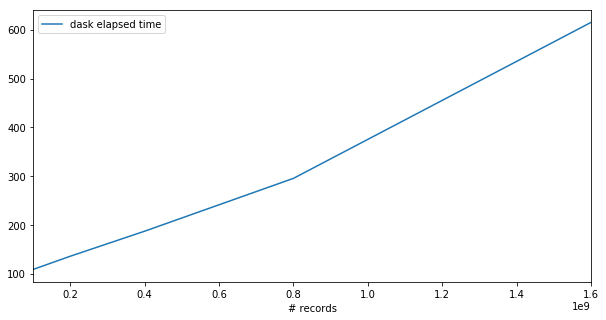

In [25]:
# Look at scaling as you increase the dataset size

scaling = pd.DataFrame([{'# records': 100000000, 'dask elapsed time': 108.579838514328},
                        {'# records': 200000000, 'dask elapsed time': 135.68784761428833},
                        {'# records': 400000000, 'dask elapsed time': 187.0207820892334},
                        {'# records': 800000000, 'dask elapsed time': 295.3570291996002},
                        {'# records': 1600000000, 'dask elapsed time': 615.1828716754914}])
scaling.plot(kind = 'line', figsize = (10, 5), x = '# records', y = ['dask elapsed time'])

In [26]:
scaling

,# records,dask elapsed time
0,100000000,108.579839
1,200000000,135.687848
2,400000000,187.020782
3,800000000,295.357029
4,1600000000,615.182872
